# Assignment 3: Classical Hough Transform

Gruppe 2: Albrecht Oster, Linus Helfmann

## Ex. 3.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

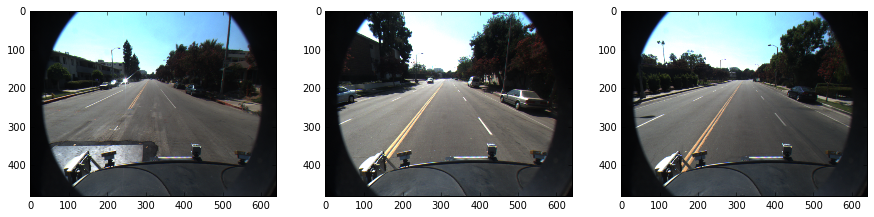

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)

ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)

In [2]:
# dieser Code wurde als Musterlösung von Sebastian Oltmanns zur Verfügung gestellt 
# und von Tim renoviert

%matplotlib inline
from skimage.draw import line
from skimage import io
import math
import numpy as np

def draw_line_hessian_normal(image, a, r):
    
    (dimy,dimx) = image.shape

    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = int(round((r - x0*math.cos(a))/math.sin(a)))
    x1 = dimx
    y1 = int(round((r - x1*math.cos(a))/math.sin(a)))

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret

## line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

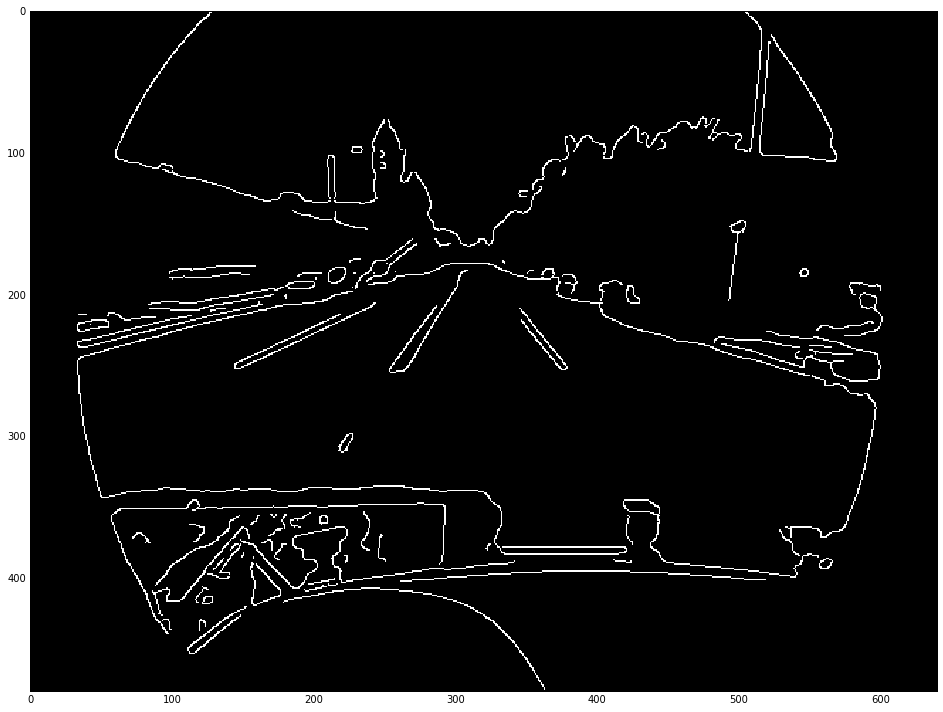

In [3]:
lane_edge = feature.canny(color.rgb2gray(lane1), 2)

fig = plt.figure(figsize=(15, 10))
io.imshow(lane_edge)

# r in [0:diagonale] weil r maximal die Diagonale des Bildes sein kann
# alpha in 0 bis 2pi
N_WINKEL = 90
N_LINIEN = 150

def getBinFromR(diagonale,r):
    return int((N_LINIEN-1)*r/(diagonale+1))

def getAlphaFromAlphaBin(a): #input: Zahl zwischen 0 und N_Winkel-1
    return a*np.pi*2/N_WINKEL #output winkel zwischen 0 und 2pi

def getRFromRBin(diagonale,rNr):
    return rNr*(diagonale+1)/(N_LINIEN-1)
    

In [4]:
def find_lines(image, filter=None):
    diagonale = np.sqrt(image.shape[0]**2 + image.shape[1]**2)
    accu = np.zeros((N_WINKEL,N_LINIEN))

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y,x]:
                for a in range(N_WINKEL):
                    alpha = getAlphaFromAlphaBin(a)
                    r = x * np.cos(alpha) + y * np.sin(alpha)                    
                    # es gibt immer 2 Lösungen, eine mit pos r und eine mit neg r
                    # wir können also die mit neg. r ignorieren
                    if r >= 0 and (filter == None or filter(alpha,r)):           
                        rNr = getBinFromR(diagonale, r)
                        accu[a,rNr] = accu[a,rNr]+1
    return accu

In [5]:
def draw_lines(image,accu,lines=10):
    diagonale = np.sqrt(image.shape[0]**2 + image.shape[1]**2)
    ausgabe = np.zeros(image.shape)

    data = []
    for a in range(N_WINKEL):
        for r in range(N_LINIEN):
            if accu[a,r] > 0:
                data.append((accu[a,r],a,r))
    # sortieren
    data.sort(key=lambda tup: tup[0], reverse=True)
    # die 10 besten zeichnen
    for (v,a,r) in data[0:lines]:
        ausgabe = draw_line_hessian_normal(ausgabe, getAlphaFromAlphaBin(a), \
                                           getRFromRBin(diagonale,r))
        
    io.imshow(ausgabe)

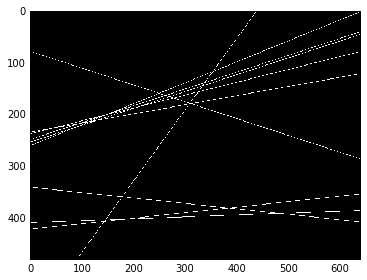

In [6]:
# Alle Linien
accu = find_lines(lane_edge)
draw_lines(lane_edge,accu)

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


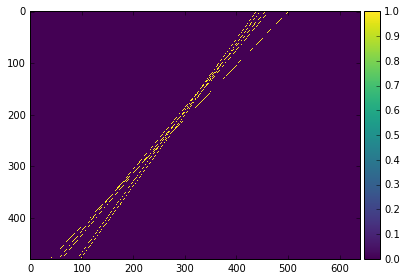

In [7]:
# gefiltert
def filter(alpha,r):
    # wir suchen Winkel mit -45° <= alpha <= 45°
    return alpha >= 1.75*np.pi or alpha <= 0.25*np.pi 

accu = find_lines(lane_edge,filter)
draw_lines(lane_edge,accu,5)

## circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

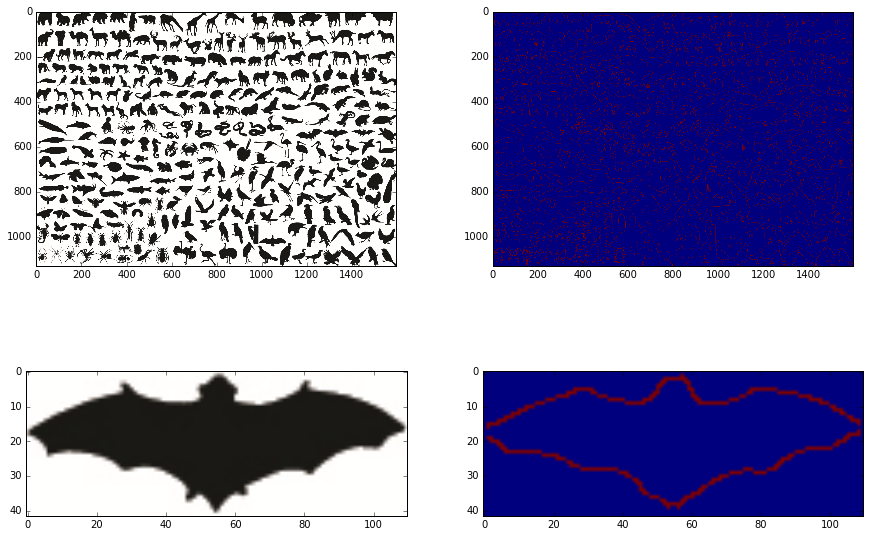

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
from scipy import ndimage
import numpy as np

animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]
bat_gray = color.rgb2gray(bat)
bat_edge = feature.canny(bat_gray, 2)
animals_gray = color.rgb2gray(animals)
animals_edge = feature.canny(animals_gray, 2)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

ax1.imshow(animals)
ax2.imshow(animals_edge)
ax3.imshow(bat)
ax4.imshow(bat_edge)

In [9]:
def getGradientConv(image):
    Sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy = Sx.T
    Gx = ndimage.convolve(image, Sx)
    Gy = ndimage.convolve(image, Sy)
    return math.atan2(Gy[1,1],Gx[1,1])*180/np.pi % 360

In [10]:
R_WINKEL = 18
def getBin(a): #erwartet 360°!
    return int(a*R_WINKEL/360) % R_WINKEL

r = {}
for a in range(R_WINKEL):
    r[a] = []

# Mittelpunkt
mx = 55
my = 20

# R-Tabelle berechnen
for x in range(bat.shape[1]):
    for y in range(bat.shape[0]):
        if bat_edge[y,x] == 1:
            local_image = bat_gray[y-1:y+2,x-1:x+2]
            theta = getGradientConv(local_image)
            aNr = getBin(theta)
            vectors = r[aNr]
            vectors.append((mx-x,my-y))
            r[aNr] = vectors

In [11]:
found = np.zeros(animals_edge.shape)

# potentielle Mittelpunkte markieren
for x in range(animals.shape[1]):
    for y in range(animals.shape[0]):
        if animals_edge[y,x] == 1:
            local_image = animals_gray[y-1:y+2,x-1:x+2]
            theta = getGradientConv(local_image)
            aNr = getBin(theta)
            for (vx,vy) in r[aNr]:
                if 0 <= x+vx and x+vx < animals.shape[1] and 0 <= y+vy and \
                                                y+vy < animals.shape[0]:
                    found[y+vy,x+vx] = found[y+vy,x+vx] + 1

In [12]:
def drawBox(image,x,y,xdiff,ydiff):
    new_image = image.copy()
    for xa in range(x-xdiff,x+xdiff+1):
        for ya in [y-ydiff,y-ydiff-1,y-ydiff-2,y-ydiff-3, \
                   y+ydiff,y+ydiff+1,y+ydiff+2,y+ydiff+3]:
            new_image[ya,xa] = np.array([255,0,0])
        
    for ya in range(y-ydiff,y+ydiff+1):
        for xa in [x-xdiff,x-xdiff-1,x-xdiff-2,x-xdiff-3, \
                   x+xdiff,x+xdiff+1,x+xdiff+2,x+xdiff+3]:
            new_image[ya,xa] = np.array([255,0,0])
        
    return new_image

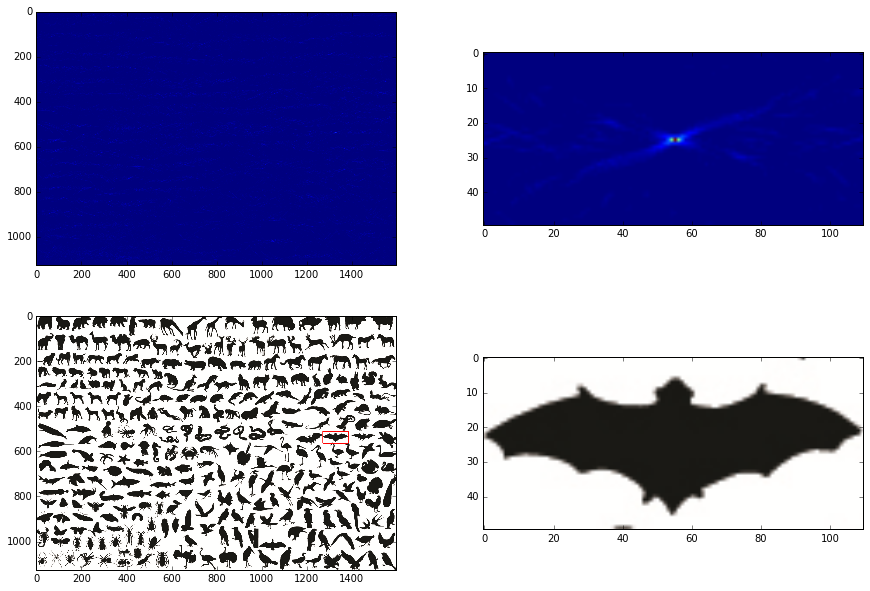

In [13]:
# Mittelpunkt:
(y,x) = np.unravel_index(np.argmax(found, axis=None), found.shape)


fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)


ax1.imshow(found)
ax2.imshow(found[y-25:y+25, x-55:x+55])
ax3.imshow(drawBox(animals,x,y,55,25))
ax4.imshow(animals[y-25:y+25, x-55:x+55])

* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)